all rights reserved@cimple-chandu

In [ ]:
import numpy as np 
import pandas as pd 
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

DATASET_DIR = "C:/Users/CSEGPUs-03/Downloads/archive (2)/Rice_Leaf_AUG/Rice_Leaf_AUG"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

datagen = ImageDataGenerator(rescale=1./255)
all_data_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

filenames = all_data_gen.filepaths
classes = all_data_gen.classes
class_labels = list(all_data_gen.class_indices.keys())

data = pd.DataFrame({
    'filename': filenames,
    'class': [class_labels[k] for k in classes]
})

train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['class'], random_state=SEED)
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['class'], random_state=SEED)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 13840 images belonging to 10 classes.
Found 11072 validated image filenames belonging to 10 classes.
Found 1384 validated image filenames belonging to 10 classes.
Found 1384 validated image filenames belonging to 10 classes.


In [6]:
print(class_labels)

['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Narrow Brown Leaf Spot', 'Neck_Blast', 'Rice Hispa', 'Sheath Blight', 'tungro']


Error loading image from G:\My Drive\Rice_Leaf_AUG\Neck Blast\IMG20201108163458_00.jpg. Skipping this image.


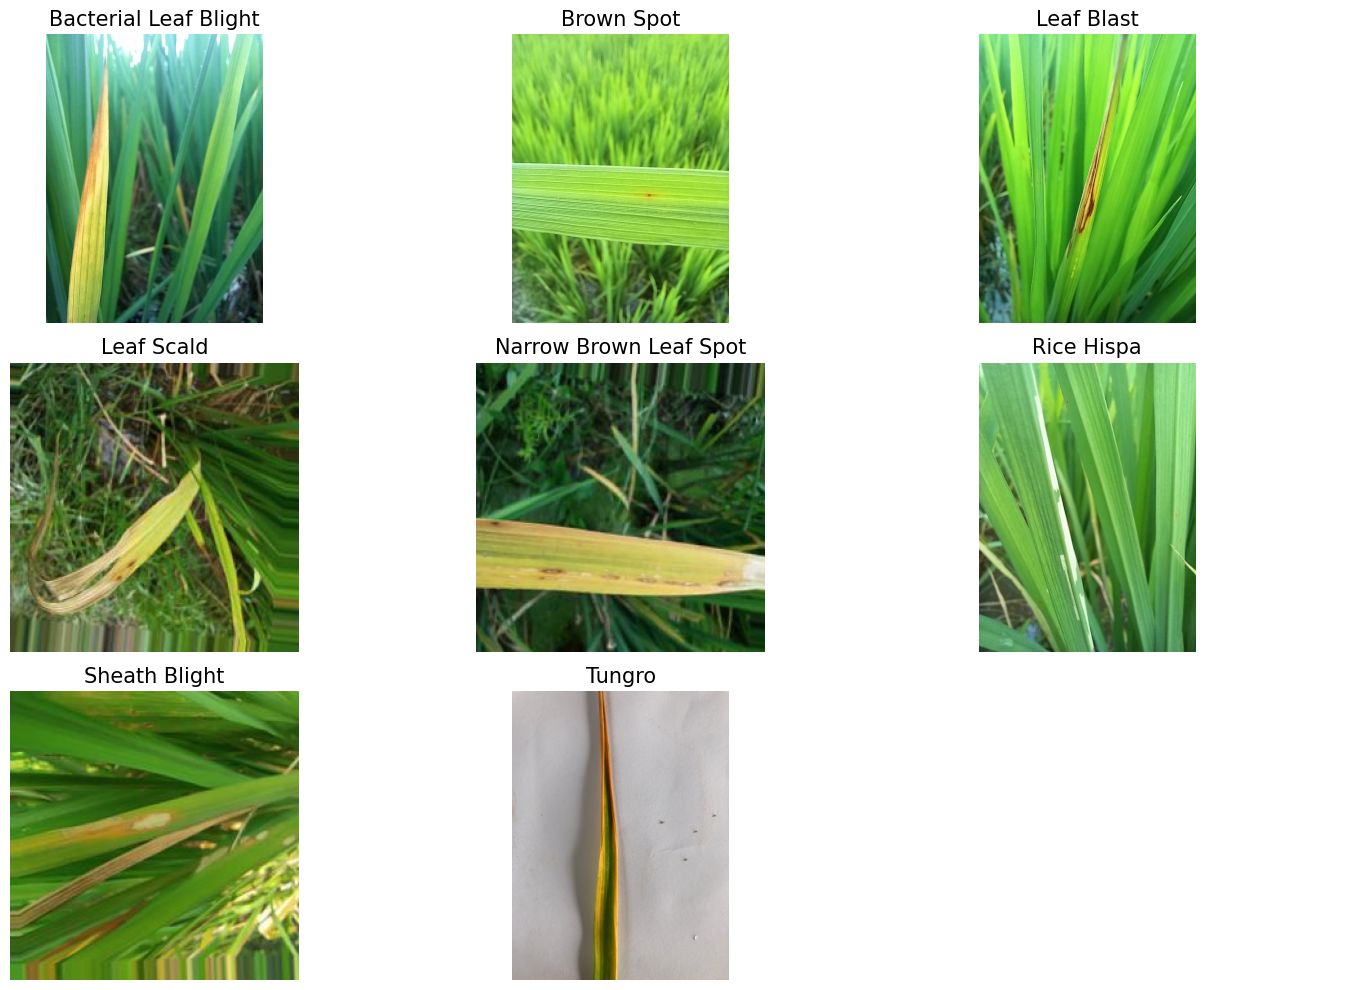

In [18]:
import cv2
import matplotlib.pyplot as plt
import os

# Define the directories
BacterialLeafBlight = os.listdir(r"G:\My Drive\Rice_Leaf_AUG\Bacterial Leaf Blight")
BrownSpot = os.listdir(r"G:\My Drive\Rice_Leaf_AUG\Brown Spot")
LeafBlast = os.listdir(r"G:\My Drive\Rice_Leaf_AUG\Leaf Blast")
Leafscald = os.listdir(r"G:\My Drive\Rice_Leaf_AUG\Leaf scald")
NarrowBrownLeafSpot = os.listdir(r"G:\My Drive\Rice_Leaf_AUG\Narrow Brown Leaf Spot")
RiceHispa = os.listdir(r"G:\My Drive\Rice_Leaf_AUG\Rice Hispa")
ShealthBlight = os.listdir(r"G:\My Drive\Rice_Leaf_AUG\Sheath Blight")
Tungro = os.listdir(r"G:\My Drive\Rice_Leaf_AUG\tungro")
NeckBlast = os.listdir(r"G:\My Drive\Rice_Leaf_AUG\Neck_Blast")

# List of directories and corresponding titles
directories = [
    (BacterialLeafBlight, 'Bacterial Leaf Blight'),
    (BrownSpot, 'Brown Spot'),
    (LeafBlast, 'Leaf Blast'),
    (Leafscald, 'Leaf Scald'),
    (NarrowBrownLeafSpot, 'Narrow Brown Leaf Spot'),
    (RiceHispa, 'Rice Hispa'),
    (ShealthBlight, 'Sheath Blight'),
    (Tungro, 'Tungro'),
    (NeckBlast, 'Neck Blast')
]

# Create the figure with a specific canvas size
plt.figure(figsize=(15, 10), facecolor='white')  # Set canvas size

# Loop through the directories and plot one image from each
for i, (img_list, title) in enumerate(directories):
    plt.subplot(3, 3, i + 1)  # 3 rows, 3 columns for 9 images
    
    # Check if the directory is not empty and select the first image
    if img_list:
        img_path = os.path.join(r"G:\My Drive\Rice_Leaf_AUG", title, img_list[0])  # Use the first image in each class
        
        # Read the image
        img = cv2.imread(img_path)
        
        # Check if the image was loaded correctly
        if img is not None:
            # Convert the image from BGR to RGB because OpenCV reads in BGR format
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Display the image
            plt.imshow(img_rgb)
            plt.title(title, fontsize=15)  # Title as class name
            plt.axis('off')  # Hide the axis for a cleaner display
        else:
            print(f"Error loading image from {img_path}. Skipping this image.")
            plt.axis('off')  # If there's an error, hide the axis and move to the next plot
    else:
        print(f"No images found in directory: {title}. Skipping this directory.")
        plt.axis('off')  # If no images, skip the subplot and hide the axis

# Adjust layout to ensure the images do not overlap
plt.tight_layout()

# Show the plot
plt.show()


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.callbacks import EarlyStopping

#Load the DenseNet169 model pre-trained on ImageNet
model = DenseNet169(
    weights='imagenet',      # Use pre-trained weights on ImageNet
    include_top=False,       # Exclude the fully connected layer at the top
    input_shape=(224, 224, 3) # Specify the input shape of images (224x224x3)
)

# Freeze the base model (DenseNet169) layers so they don't get trained
model.trainable = True

# Build the model on top of DenseNet169
model = models.Sequential([
    model,  # Add the DenseNet169 model as a base
    layers.GlobalAveragePooling2D(),   # Global average pooling
    layers.Dense(512, activation='relu'),  # Add a dense layer
    layers.Dropout(0.5),  # Add dropout to prevent overfitting
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes (adjust according to your use case)
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)

# Print the model summary
model.summary()

# Example of using ImageDataGenerator for data augmentation (if you have data generators)


# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=3,               # Stop after 3 epochs without improvement
    restore_best_weights=True # Restore the best model weights when training stops
)



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)        │ (None, 7, 7, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       852,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,500,490 (51.50 MB)

 Trainable params: 13,342,090 (50.90 MB)

 Non-trainable params: 158,400 (618.75 KB)

c:\Users\CSEGPUs-03\AppData\Local\Programs\Python\Python312\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


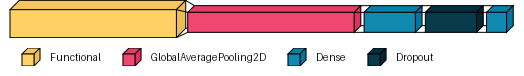

<Figure size 1500x1000 with 0 Axes>

In [19]:
plt.figure(figsize=(15,10),facecolor="white")
import visualkeras
visualkeras.layered_view(model,legend=True)

In [17]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=50,                 # Number of epochs
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,  # Replace with your validation data generator
    validation_steps=val_generator.samples // val_generator.batch_size,  # Adjust this as per your validation data
    callbacks=[early_stopping]  # Include EarlyStopping callback
)

Epoch 1/50


c:\Users\CSEGPUs-03\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


162/346 ━━━━━━━━━━━━━━━━━━━━ 19:27 6s/step - accuracy: 0.2268 - loss: 2.3267

In [3]:
from tensorflow .keras.models import load_model

In [5]:
model=load_model(r'G:\My Drive\final_models\densenet169_97.h5')

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam

In [13]:
model.trainable=True

# Re-compile the model after unfreezing layers
model.compile(optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)        │ (None, 7, 7, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       852,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,500,490 (51.50 MB)

 Trainable params: 857,610 (3.27 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [14]:
# Continue training (fine-tuning)
history_fine_tune = model.fit(
    train_generator,
    epochs=10,  # Set the number of epochs
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10


c:\Users\CSEGPUs-03\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


346/346 ━━━━━━━━━━━━━━━━━━━━ 283s 796ms/step - accuracy: 0.9730 - loss: 0.0857 - val_accuracy: 0.9600 - val_loss: 0.1422
Epoch 2/10


c:\Users\CSEGPUs-03\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0154
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 293s 844ms/step - accuracy: 0.9740 - loss: 0.0770 - val_accuracy: 0.9586 - val_loss: 0.1385
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0509
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 279s 804ms/step - accuracy: 0.9813 - loss: 0.0618 - val_accuracy: 0.9578 - val_loss: 0.1367
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0362
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 342s 981ms/step - accuracy: 0.9832 - loss: 0.0555 - val_accuracy: 0.9593 - val_loss: 0.1354
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0251
Epoch 9/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 306s 879ms/step - accurac

In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

1384/1384 ━━━━━━━━━━━━━━━━━━━━ 93s 67ms/step - accuracy: 0.9645 - loss: 0.1118
Test accuracy: 0.97


In [ ]:
model.save(r'G:\My Drive\densenet169_97.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


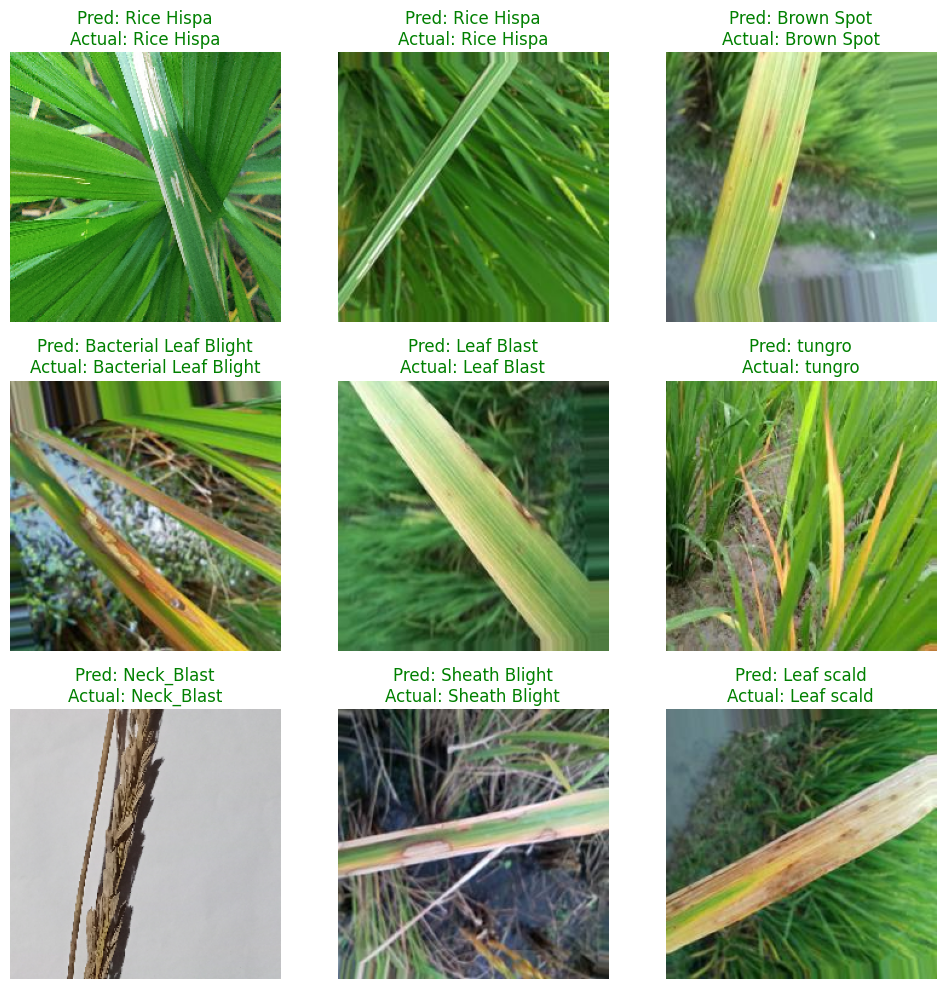

In [20]:
filenames = test_generator.filenames
classes = test_generator.classes
labels = list(test_generator.class_indices.keys())

random_indices = random.sample(range(len(filenames)), 9)
images = []
actual_labels = []
predicted_labels = []

for idx in random_indices:
    img, label = test_generator[idx]
    images.append(img[0])
    actual_labels.append(classes[idx])
    pred = model.predict(img)
    predicted_labels.append(np.argmax(pred))

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    actual_class = labels[actual_labels[i]]
    predicted_class = labels[predicted_labels[i]]
    color = 'green' if actual_class == predicted_class else 'red'
    plt.title(f"Pred: {predicted_class}\nActual: {actual_class}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

Total steps (batches to process): 1384
   3/1384 ━━━━━━━━━━━━━━━━━━━━ 1:18 57ms/step - accuracy: 1.0000 - loss: 0.0572

c:\Users\CSEGPUs-03\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1384/1384 ━━━━━━━━━━━━━━━━━━━━ 80s 56ms/step - accuracy: 0.9645 - loss: 0.1118
Test Loss: 0.11572457104921341
Test Accuracy: 0.9660404920578003
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━

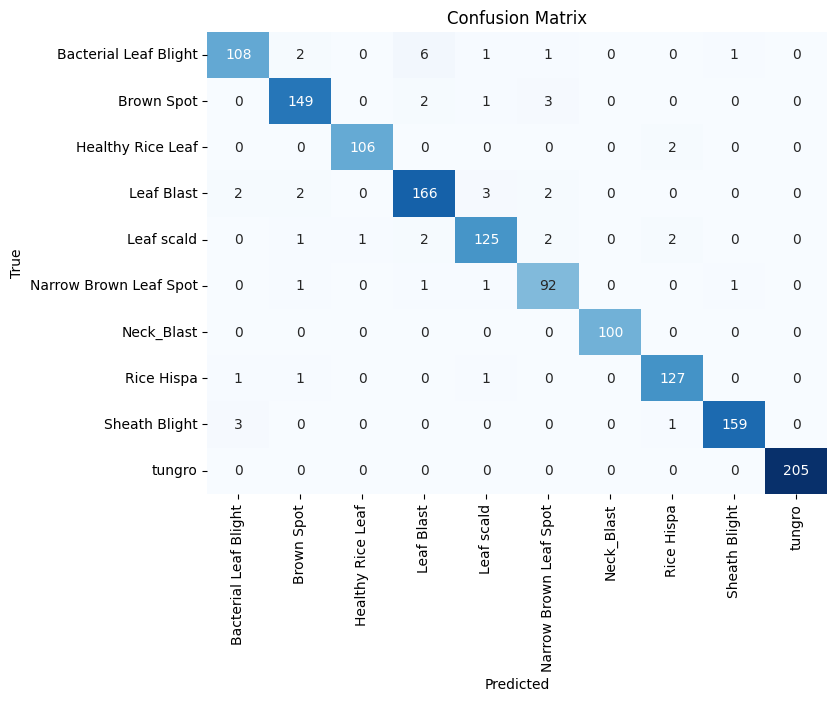

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have these from your trained model
# test_generator: A generator that yields batches of data (X, y)
# model: Your trained Keras/TensorFlow model

# Calculate number of steps based on the number of test images and batch size
steps = np.ceil(test_generator.samples / test_generator.batch_size).astype(int)
print(f"Total steps (batches to process): {steps}")

# Step 1: Evaluate the model on the test generator (optional, if you need to see loss/accuracy)
score = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

# Step 2: Predict the labels on the entire test dataset from the test generator
y_true = []
y_pred = []

# Loop over the test generator and collect the results
for i, (X_batch, y_batch) in enumerate(test_generator):
    y_batch_pred = model.predict(X_batch)  # Get predictions for the batch
    
    y_true.extend(np.argmax(y_batch, axis=1))  # True labels
    y_pred.extend(np.argmax(y_batch_pred, axis=1))  # Predicted labels
    
    # Stop once we have reached the defined number of steps
    if i + 1 >= steps:
        break  # Exit after processing the desired number of batches

# Convert lists to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 3: Generate the Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 4: Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import  classification_report, roc_curve, auc
from sklearn.metrics import  f1_score, precision_score, recall_score

In [9]:
precision = precision_score(y_true, y_pred, average='macro')  # Change to 'micro', 'macro', or 'weighted' for multi-class
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.9648
Recall: 0.9649
F1-Score: 0.9648


In [16]:
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       119
           1       0.96      0.96      0.96       155
           2       0.99      0.98      0.99       108
           3       0.94      0.95      0.94       175
           4       0.95      0.94      0.94       133
           5       0.92      0.96      0.94        96
           6       1.00      1.00      1.00       100
           7       0.96      0.98      0.97       130
           8       0.99      0.98      0.98       163
           9       1.00      1.00      1.00       205

    accuracy                           0.97      1384
   macro avg       0.96      0.96      0.96      1384
weighted avg       0.97      0.97      0.97      1384



In [11]:
y_prob = model.predict(test_generator, verbose=1)

1384/1384 ━━━━━━━━━━━━━━━━━━━━ 78s 55ms/step


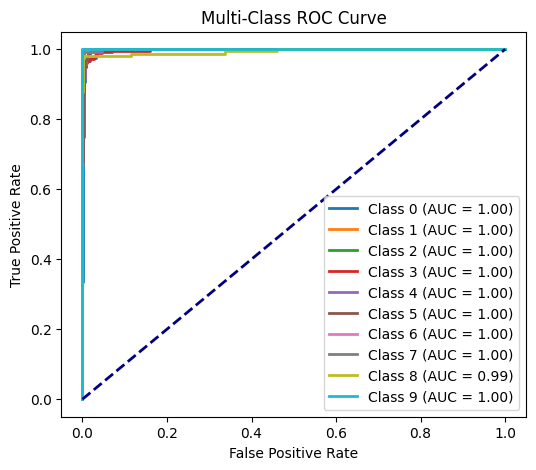

In [12]:
if y_prob.shape[1] > 2:  # Multi-class classification
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(y_prob.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])  # Binarize for each class
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(6, 5))
    for i in range(len(roc_auc)):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [17]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = tf.keras.models.load_model(r'G:\My Drive\final_models\densenet169_97.h5')

def predict_rice_disease(img):
    # Preprocess the image to the correct format for the model
    img = img.resize((224, 224))  # Assuming the model expects 224x224 images
    img_array = np.array(img) / 255.0  # Normalize if needed
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions, axis=-1)[0]  # Get the index of the predicted class
    
    # Map the predicted class index to the disease name (modify according to your class names)
    class_names = ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Narrow Brown Leaf Spot', 'Neck_Blast', 'Rice Hispa', 'Sheath Blight', 'tungro'] # Example class names
    return class_names[class_idx]
# Create Gradio interface
interface = gr.Interface(
    fn=predict_rice_disease,  # The function to call for predictions
    inputs=gr.Image(type="pil"),  # Input is an image in PIL format
    outputs=gr.Textbox(),  # Output is a text label showing the disease name
    title="Rice Disease Detection",  # Title of the interface
    description="Upload an image of a rice leaf to detect its disease.",  # Description of the app
)

# Launch the interface
interface.launch()


c:\Users\CSEGPUs-03\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.
